In [1]:
from bound_probs.utils.data import get_dataset
from bound_probs.cogmodels import build_model
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = get_dataset()

In [6]:
sns.color_palette('icefire', 3)

[(0.25423116, 0.40433127, 0.78155831),
 (0.12284806, 0.1179729, 0.11772022),
 (0.72401436, 0.20691287, 0.25027366)]

In [ ]:
sns.relplot(df.reset_index(), col='subject', hue='probRange', style='noiseType', col_wrap=5,
            hue_order=('00to050', '00to100', '50to100'),
                  x='p_bin2', y='bias',
                  facet_kws={'sharey': False, 'sharex': True},
                  kind='line')
            )

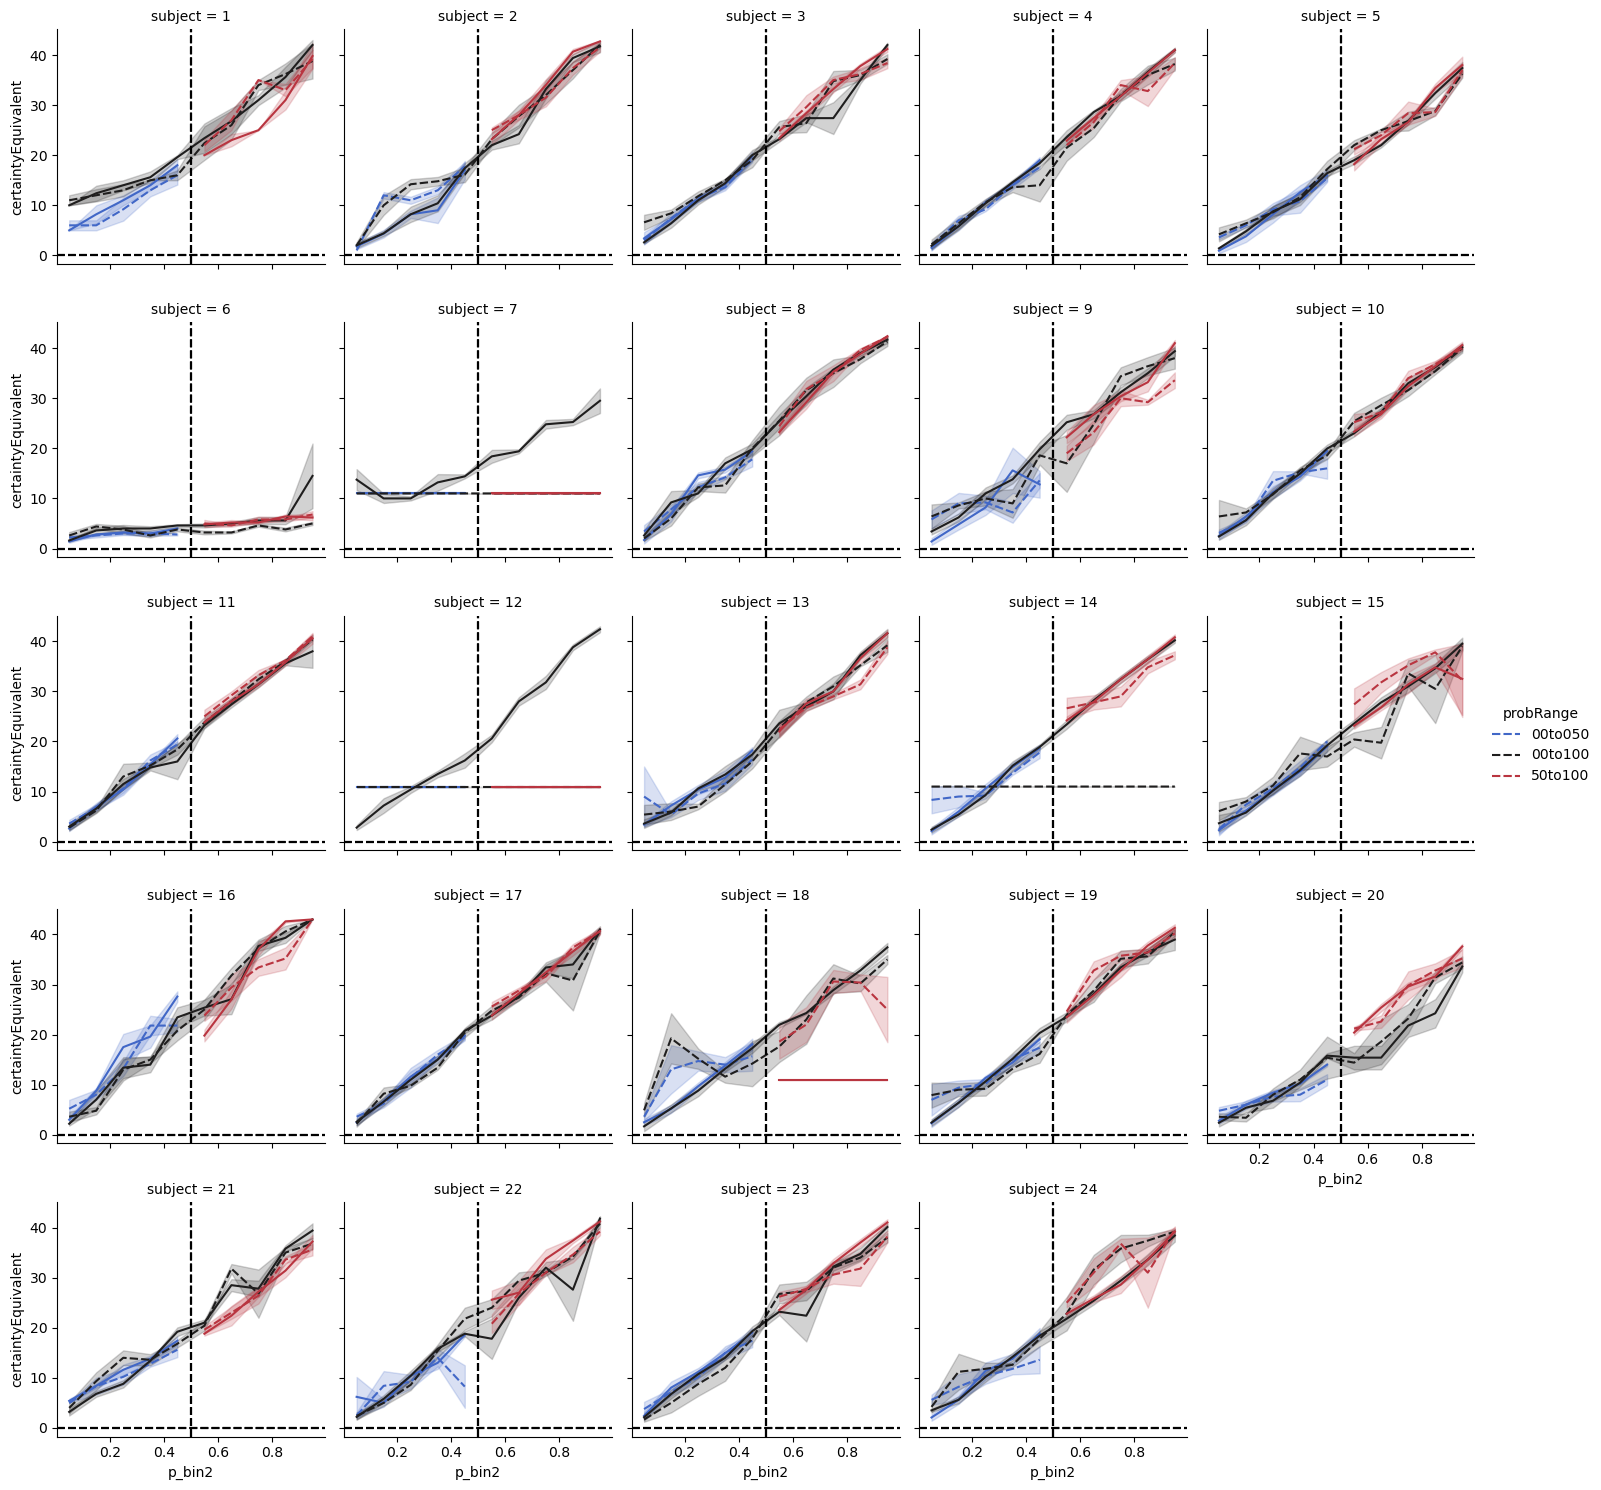

In [23]:
g = sns.FacetGrid(df.reset_index(), col='subject', hue='probRange', col_order=subjects, col_wrap=5, 
                #   palette=['blue', 'gray', 'red'], 
                palette=sns.color_palette('icefire', 3),
                  hue_order=('00to050', '00to100', '50to100'))
g.map_dataframe(sns.lineplot, x='p_bin2', y='certaintyEquivalent', errorbar='se', style='noiseType')

g.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))
g.map(lambda *args, **kwargs: plt.axvline(0.5, c='k', ls='--'))
g.add_legend()

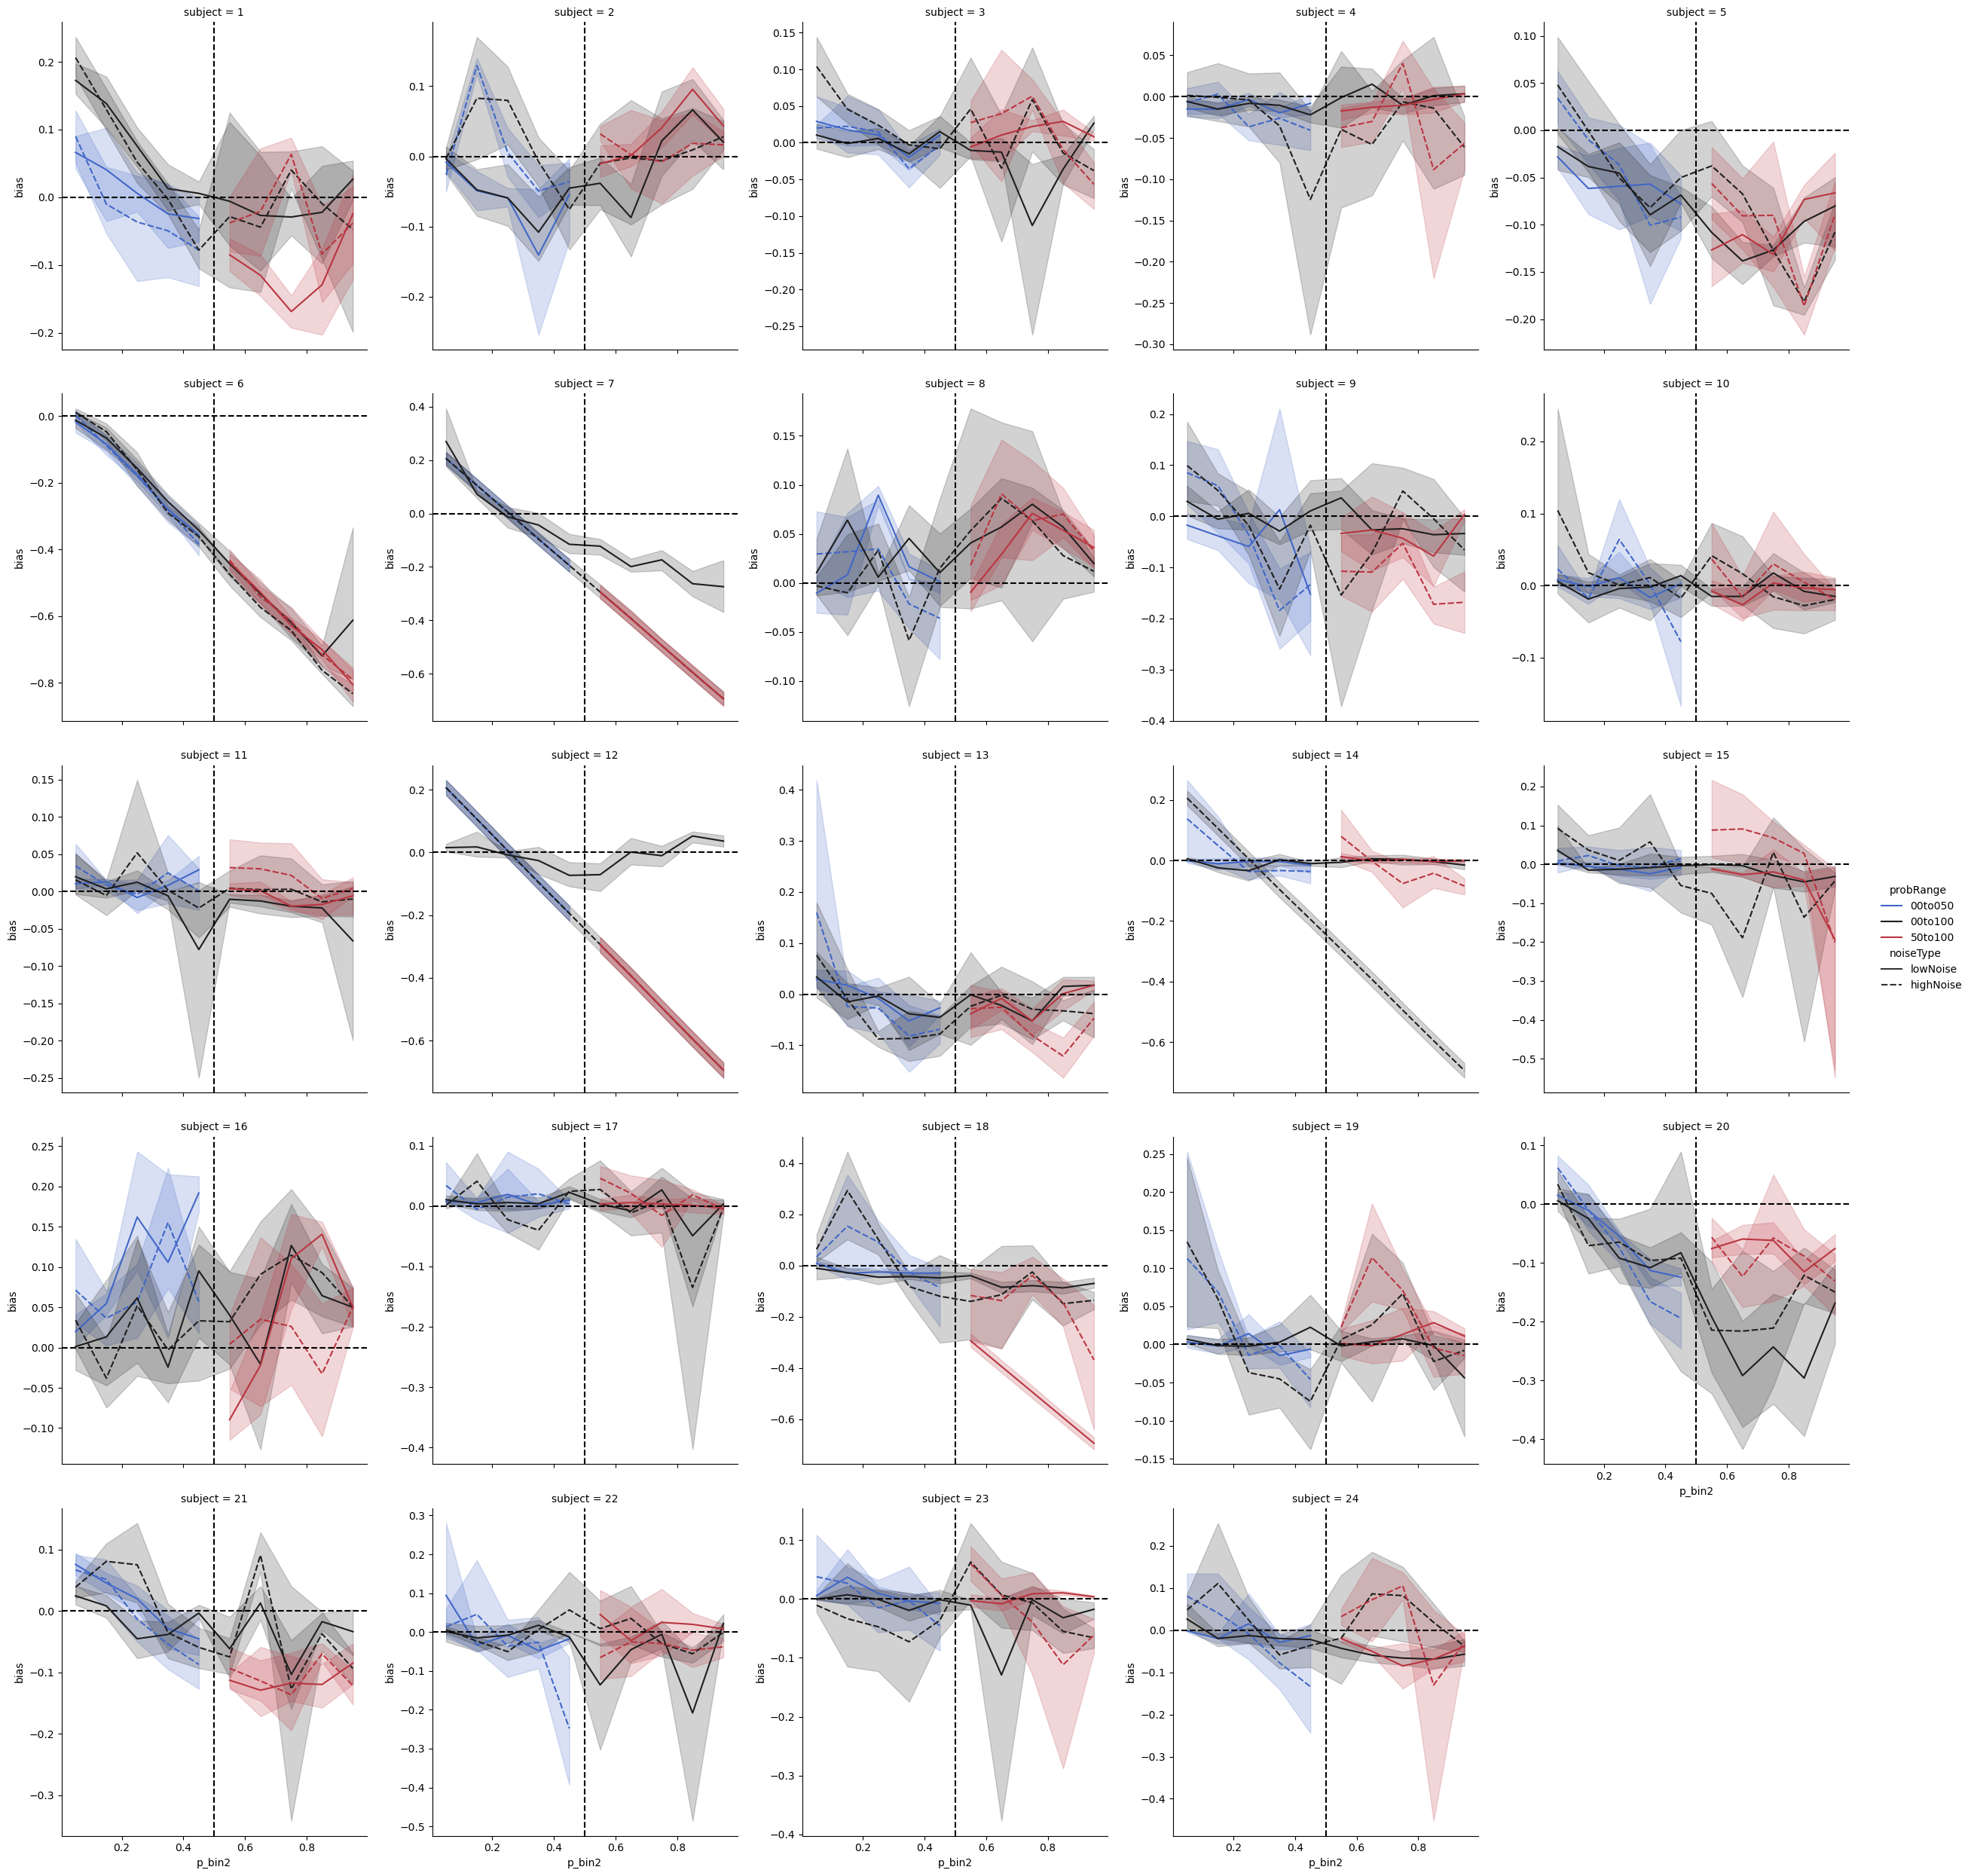

In [17]:
g = sns.relplot(data=df.reset_index(), hue='probRange',
                palette=sns.color_palette('icefire', 3),
                style='noiseType',
                col='subject',
                col_wrap=5,
                  hue_order=('00to050', '00to100', '50to100'),
                  x='p_bin2', y='bias',
                  facet_kws={'sharey': False, 'sharex': True},
                  kind='line')
                  
# g.set(sharey=False)

g.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))
g.map(lambda *args, **kwargs: plt.axvline(0.5, c='k', ls='--'))
# g.add_legend()

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_27404/489182062.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  g = sns.relplot(data=df.groupby(['subject', 'p_bin', 'probRange', 'noiseType']).mean().reset_index(), hue='probRange',


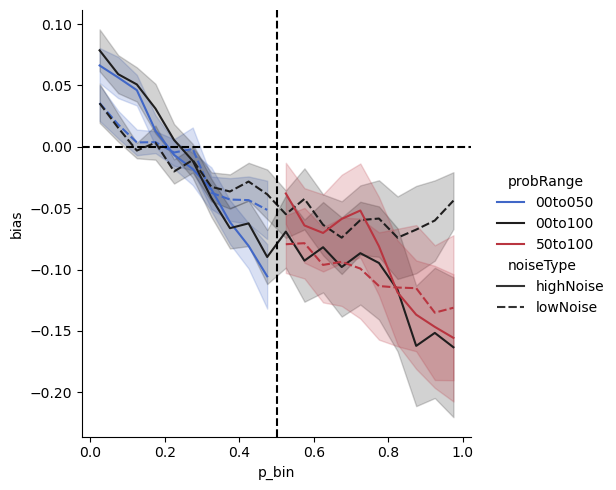

In [27]:
g = sns.relplot(data=df.groupby(['subject', 'p_bin', 'probRange', 'noiseType']).mean().reset_index(), hue='probRange',
                palette=sns.color_palette('icefire', 3),
                style='noiseType',
                  hue_order=('00to050', '00to100', '50to100'),
                  x='p_bin', y='bias',
                  kind='line',
                  errorbar='se',
                  height=5)

g.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))
g.map(lambda *args, **kwargs: plt.axvline(0.5, c='k', ls='--'))

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_27404/2246875868.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  g = sns.relplot(data=df.drop([6,7,12,18], level='subject').groupby(['subject', 'p_bin', 'probRange', 'noiseType']).mean().reset_index(), hue='probRange',


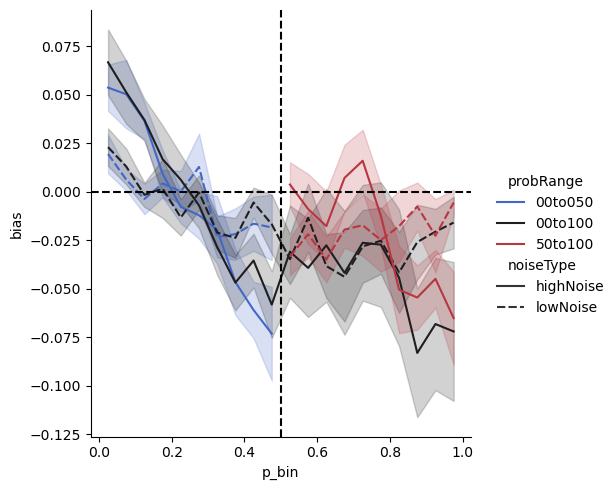

In [28]:
g = sns.relplot(data=df.drop([6,7,12,18], level='subject').groupby(['subject', 'p_bin', 'probRange', 'noiseType']).mean().reset_index(), hue='probRange',
                palette=sns.color_palette('icefire', 3),
                style='noiseType',
                  hue_order=('00to050', '00to100', '50to100'),
                  x='p_bin', y='bias',
                  kind='line',
                  errorbar='se',
                  height=5)

g.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))
g.map(lambda *args, **kwargs: plt.axvline(0.5, c='k', ls='--'))

In [32]:
from patsy import dmatrix
import pymc as pm
from bound_probs.utils.math import inverse_softplus_np
import pytensor.tensor as pt

def build_model(data, dof_splines=6):

    sub_ix, subject_mapping = pd.factorize(data.index.get_level_values('subject'))
    noise_ix, noise_mapping = pd.factorize(data['noiseType'])
    probrange_ix, probrange_mapping = pd.factorize(data['probRange'])

    # Different design matrix for low prob and high prob range!
    X_p = [dmatrix(f'bs(p, df={dof_splines}, degree=3, include_intercept=True, lower_bound=0.0, upper_bound=0.5) - 1', {'p':np.clip(data['p'], 0.0, 0.5)}),
        dmatrix(f'bs(p, df={dof_splines}, degree=3, include_intercept=True, lower_bound=.5, upper_bound=1.0) - 1', {'p':np.clip(data['p'], .5, 1.0)})]
    X_p = np.array(X_p)

    # Select appropriate design matrix per trial
    X_p = X_p[probrange_ix, np.arange(X_p.shape[1])]

    coords = {'subject': subject_mapping, 'spline_n': np.arange(dof_splines), 'noise_condition':df.noiseType.unique(), 'probRange':df.probRange.unique()}

    model = pm.Model(coords=coords)

    with model:

        beta_bias_mu = pm.Normal('beta_bias_mu', mu=0, sigma=.05, dims=('noise_condition', 'probRange', 'spline_n'))
        beta_bias_sd = pm.HalfCauchy('beta_bias_sd', .05, dims=('noise_condition', 'probRange', 'spline_n'))
        
        beta_sd_mu = pm.Normal('beta_sd_mu', mu=inverse_softplus_np(.1), sigma=1., dims=('noise_condition', 'probRange', 'spline_n'))
        beta_sd_sd = pm.HalfCauchy('beta_sd_sd', .05, dims=('noise_condition', 'probRange', 'spline_n'))

        subject_offset_bias = pm.Normal(f'beta_bias_offset', mu=0, sigma=1, dims=('subject', 'noise_condition', 'probRange', 'spline_n'))
        subject_offset_sd = pm.Normal(f'beta_d_offset', mu=0, sigma=1, dims=('subject', 'noise_condition', 'probRange', 'spline_n'))

        beta_bias = pm.Deterministic('beta_bias', beta_bias_mu + subject_offset_bias * beta_bias_sd, dims=('subject', 'noise_condition', 'probRange', 'spline_n'))
        beta_sd = pm.Deterministic('beta_sd', beta_sd_mu + subject_offset_sd * beta_sd_sd, dims=('subject', 'noise_condition', 'probRange', 'spline_n'))


        print(beta_bias[sub_ix, noise_ix, probrange_ix, :].shape.eval())

        print(X_p.shape)

        # pred_bias = pm.math.dot(X_p, beta_bias[sub_ix, noise_ix, probrange_ix, :])
        pred_bias = pt.sum(X_p * beta_bias[sub_ix, noise_ix, probrange_ix, :], axis=1)
        pred_sd = pt.softplus(pt.sum(X_p * beta_sd[sub_ix, noise_ix, probrange_ix, :], axis=1))

        ll = pm.Normal('pred', mu=pred_bias, sigma=pred_sd, observed=data['bias'].values)

    return model

In [47]:
data = df.copy()
dof_splines = 6


sub_ix, subject_mapping = pd.factorize(data.index.get_level_values('subject'))
noise_ix, noise_mapping = pd.factorize(data['noiseType'])
probrange_ix, probrange_mapping = pd.factorize(data['probRange'])

# Different design matrix for low prob and high prob range!
X_p_ = [dmatrix(f'bs(p, df={dof_splines*2}, degree=3, include_intercept=True, lower_bound=0.0, upper_bound=1.0) - 1', {'p':np.clip(data['p'], 0.0, 1.0)}),
       dmatrix(f'bs(p, df={dof_splines}, degree=3, include_intercept=True, lower_bound=.5, upper_bound=1.0) - 1', {'p':np.clip(data['p'], .5, 1.0)}),
       dmatrix(f'bs(p, df={dof_splines}, degree=3, include_intercept=True, lower_bound=0.0, upper_bound=0.5) - 1', {'p':np.clip(data['p'], 0.0, 0.5)})]
# X_p = np.array(X_p)

X_p = np.zeros((3, data.shape[0], dof_splines*2))
X_p[0] = X_p_[0]
X_p[1, :, :dof_splines] = X_p_[1]
X_p[2, :, :dof_splines] = X_p_[2]
# X_p

# Select appropriate design matrix per trial
X_p = X_p[probrange_ix, np.arange(X_p.shape[1])]

coords = {'subject': subject_mapping, 'spline_n': np.arange(dof_splines*2), 'noise_condition':df.noiseType.unique(), 'probRange':df.probRange.unique()}

model = pm.Model(coords=coords)

with model:

    beta_bias_mu = pm.Normal('beta_bias_mu', mu=0, sigma=.05, dims=('noise_condition', 'probRange', 'spline_n'))
    beta_bias_sd = pm.HalfCauchy('beta_bias_sd', .05, dims=('noise_condition', 'probRange', 'spline_n'))
    
    beta_sd_mu = pm.Normal('beta_sd_mu', mu=inverse_softplus_np(.1), sigma=1., dims=('noise_condition', 'probRange', 'spline_n'))
    beta_sd_sd = pm.HalfCauchy('beta_sd_sd', .05, dims=('noise_condition', 'probRange', 'spline_n'))

    subject_offset_bias = pm.Normal(f'beta_bias_offset', mu=0, sigma=1, dims=('subject', 'noise_condition', 'probRange', 'spline_n'))
    subject_offset_sd = pm.Normal(f'beta_d_offset', mu=0, sigma=1, dims=('subject', 'noise_condition', 'probRange', 'spline_n'))

    beta_bias = pm.Deterministic('beta_bias', beta_bias_mu + subject_offset_bias * beta_bias_sd, dims=('subject', 'noise_condition', 'probRange', 'spline_n'))
    beta_sd = pm.Deterministic('beta_sd', beta_sd_mu + subject_offset_sd * beta_sd_sd, dims=('subject', 'noise_condition', 'probRange', 'spline_n'))


    print(beta_bias[sub_ix, noise_ix, probrange_ix, :].shape.eval())

    print(X_p.shape)

    # pred_bias = pm.math.dot(X_p, beta_bias[sub_ix, noise_ix, probrange_ix, :])
    pred_bias = pt.sum(X_p * beta_bias[sub_ix, noise_ix, probrange_ix, :], axis=1)
    pred_sd = pt.softplus(pt.sum(X_p * beta_sd[sub_ix, noise_ix, probrange_ix, :], axis=1))

    ll = pm.Normal('pred', mu=pred_bias, sigma=pred_sd, observed=data['bias'].values)

# return model

[4800   12]
(4800, 12)


/Users/gdehol/mambaforge/lib/python3.10/site-packages/pymc/model/core.py:1356: ImputationWarning: Data in pred contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [48]:
with model:
    idata = pm.sample(1500, tune=1500, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_bias_mu, beta_bias_sd, beta_sd_mu, beta_sd_sd, beta_bias_offset, beta_d_offset, pred_unobserved]


KeyError: 0